**LIMPIEZA EDA**

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

RAW_UK = Path("data/raw/online_retail_UK_raw.csv")
PROC_DIR = Path("data/processed"); PROC_DIR.mkdir(parents=True, exist_ok=True)
TRAIN_DIR = Path("data/train"); TRAIN_DIR.mkdir(parents=True, exist_ok=True)
TEST_DIR  = Path("data/test");  TEST_DIR.mkdir(parents=True, exist_ok=True)

assert RAW_UK.exists(), "No existe data/raw/online_retail_UK_raw.csv"

In [12]:
df = pd.read_csv(RAW_UK)

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")
df = df.dropna(subset=["InvoiceDate"])

mask_credit = df["InvoiceNo"].astype(str).str.startswith("C")
df = df[~mask_credit]

df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)].copy()

df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

print("Shape limpio:", df.shape)
display(df.head())

Shape limpio: (485123, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [13]:
start = pd.to_datetime("2011-01-01")
end   = pd.to_datetime("2011-03-31")
df_trim = df[(df["InvoiceDate"] >= start) & (df["InvoiceDate"] <= end)].copy()
df_trim.to_csv(PROC_DIR / "online_retail_UK_Q1_2011.csv", index=False)
print("Guardado:", PROC_DIR / "online_retail_UK_Q1_2011.csv", "| shape:", df_trim.shape)

Guardado: data\processed\online_retail_UK_Q1_2011.csv | shape: (87095, 9)


In [14]:
ventas_dia = (
    df_trim
    .set_index("InvoiceDate")["TotalPrice"]
    .resample("D").sum()
    .asfreq("D", fill_value=0.0)
)
ventas_dia.index.name = "InvoiceDate"
ventas_dia.to_frame("TotalPrice").to_csv(PROC_DIR / "ventas_diarias.csv")
print("Guardado:", PROC_DIR / "ventas_diarias.csv", "| n_días:", len(ventas_dia))
ventas_dia.head()

Guardado: data\processed\ventas_diarias.csv | n_días: 86


InvoiceDate
2011-01-04    15478.52
2011-01-05    31243.29
2011-01-06    32429.45
2011-01-07    22656.70
2011-01-08        0.00
Freq: D, Name: TotalPrice, dtype: float64

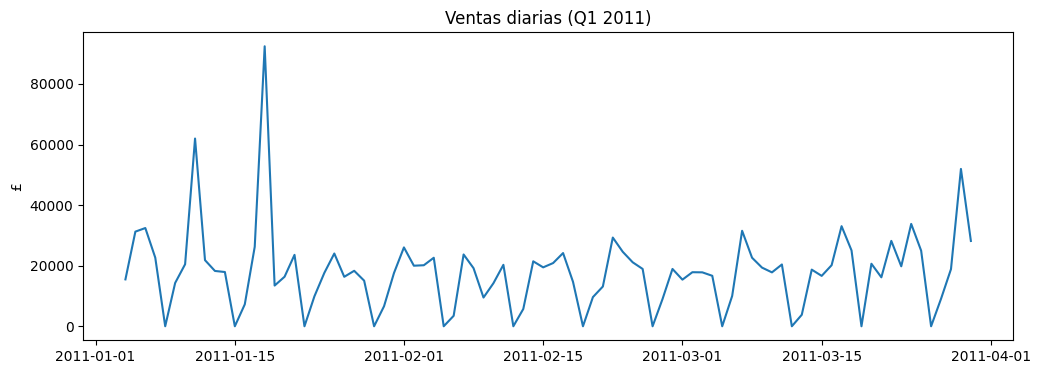

Promedio por weekday:
 weekday
0    20364.80
1    32510.09
2    20239.92
3    22287.35
4    20229.56
5        0.00
6     9114.68
Name: TotalPrice, dtype: float64

Top 5 días con mayores ventas:
 InvoiceDate
2011-01-18    92427.28
2011-01-11    61971.89
2011-03-29    51941.27
2011-03-24    33792.19
2011-03-17    33042.96
Name: TotalPrice, dtype: float64


In [15]:
plt.figure(figsize=(12,4))
plt.plot(ventas_dia.index, ventas_dia.values)
plt.title("Ventas diarias (Q1 2011)"); plt.ylabel("£"); plt.show()

tmp = ventas_dia.to_frame("TotalPrice")
tmp["weekday"] = tmp.index.weekday
print("Promedio por weekday:\n", tmp.groupby("weekday")["TotalPrice"].mean().round(2))

print("\nTop 5 días con mayores ventas:\n", ventas_dia.sort_values(ascending=False).head(5).round(2))

In [16]:
fecha_split = pd.to_datetime("2011-03-01")
train_series = ventas_dia.loc[ventas_dia.index < fecha_split]
test_series  = ventas_dia.loc[ventas_dia.index >= fecha_split]

train_series.to_frame("TotalPrice").to_csv("data/train/train_series.csv")
test_series.to_frame("TotalPrice").to_csv("data/test/test_series.csv")

print(f"Train serie: {train_series.index.min().date()} hasta {train_series.index.max().date()} - n={len(train_series)}")
print(f"Test  serie: {test_series.index.min().date()} hasta {test_series.index.max().date()} - n={len(test_series)}")

Train serie: 2011-01-04 hasta 2011-02-28 - n=56
Test  serie: 2011-03-01 hasta 2011-03-30 - n=30
